In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [36]:
# Set parameters here 
INPUT_SIZE = 128
mapping = {0:'normal', 1:'other'}
NUMCLASSES = len(mapping)
LESS_TRAIN = 5000
LESS_VAL = 2000

folder = r'C:\Users\arung\OneDrive\Desktop\COVID 19 Chest Xray\nih'

trainFolder = folder + r'\train'
valFolder = folder + r'\val'
testFolder = folder + r'\test'


In [37]:
from skimage.io import imread, imsave
from skimage.transform import resize

def make_labels(label):
    labels = np.zeros([NUMCLASSES],np.uint8)
    labels[label] = 1
    return labels
    
def train_data_with_label():
    train_images = []
    
    fileList1 = os.listdir(trainFolder + r'\normal')
    fileList1 = fileList1[:LESS_TRAIN]
    labels1 = np.zeros(len(fileList1),'uint8')
    fileList2 = os.listdir(trainFolder + r'\other')
    fileList2 = fileList2[:LESS_TRAIN]
    labels2 = np.ones(len(fileList2),'uint8')
    train_x = np.array(fileList1 + fileList2)
    train_y = np.concatenate((labels1,labels2),axis=0)
    
    for fileNum in range(train_x.shape[0]):
        fileName = trainFolder + '\\' + mapping[train_y[fileNum]]+ '\\' + train_x[fileNum]
        label = train_y[fileNum]
        img = resize(imread(fileName),(INPUT_SIZE,INPUT_SIZE))
        img /= np.amax(img)
        train_images.append([img, make_labels(label)])
    np.random.shuffle(train_images)
    return train_images

def validation_data_with_label():
    validation_images = []
    
    fileList1 = os.listdir(valFolder + r'\normal')
    fileList1 = fileList1[:LESS_VAL]   
    labels1 = np.zeros(len(fileList1),'uint8')
    fileList2 = os.listdir(valFolder + r'\other')
    fileList2 = fileList2[:LESS_VAL]  
    labels2 = np.ones(len(fileList2),'uint8')
    val_x = np.array(fileList1 + fileList2)
    val_y = np.concatenate((labels1,labels2),axis=0)
    
    for fileNum in range(val_x.shape[0]):
        fileName = valFolder + '\\' + mapping[val_y[fileNum]]+ '\\' + val_x[fileNum]
        label = val_y[fileNum]
        img = resize(imread(fileName),(INPUT_SIZE,INPUT_SIZE))
        img /= np.amax(img)
        validation_images.append([img, make_labels(label)])
    np.random.shuffle(validation_images)
    return validation_images

def test_data_with_label():
    test_images = []
    
    fileList1 = os.listdir(testFolder + r'\normal')
    labels1 = np.zeros(len(fileList1),'uint8')
    fileList2 = os.listdir(testFolder + r'\other')
    labels2 = np.ones(len(fileList2),'uint8')
    test_x = np.array(fileList1 + fileList2)
    test_y = np.concatenate((labels1,labels2),axis=0)
    
    for fileNum in range(test_x.shape[0]):
        fileName = testFolder + '\\' + mapping[test_y[fileNum]]+ '\\' + test_x[fileNum]
        label = test_y[fileNum]
        img = resize(imread(fileName),(INPUT_SIZE,INPUT_SIZE))
        img /= np.amax(img)
        test_images.append([img, make_labels(label)])
    np.random.shuffle(test_images)
    return test_images

In [38]:
# load in the train and test files
training_images = train_data_with_label()
validation_images = validation_data_with_label()
#test_images = test_data_with_label()

print((np.array(training_images)).shape)
print((np.array(validation_images)).shape)
#print((np.array(test_images)).shape)    

(10000, 2)
(4000, 2)


In [39]:
tr_img_data = np.array([i[0] for i in training_images]).reshape(-1,INPUT_SIZE,INPUT_SIZE,3)
tr_lbl_data = np.array([i[1] for i in training_images])
val_img_data = np.array([i[0] for i in validation_images]).reshape(-1,INPUT_SIZE,INPUT_SIZE,3)
val_lbl_data = np.array([i[1] for i in validation_images])


#test_img_data = np.array([i[0] for i in test_images]).reshape(-1,INPUT_SIZE,INPUT_SIZE,3)
#test_lbl_data = np.array([i[1] for i in test_images])


In [40]:
del training_images
del validation_images

In [41]:
from keras.models import Sequential
import keras
import tensorflow as tf
from keras.layers import *
from keras.optimizers import *
#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = Sequential()

model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension

model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=5,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Flatten())


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES,activation='softmax'))


model.compile(optimizer=Adam(lr=0.00002), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 64)        51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 128)      

In [32]:
#Training
c_weights = {0: 0.4, 1: 0.6}
history = model.fit(x=tr_img_data,y=tr_lbl_data,epochs=100,
                    batch_size=8,verbose=1,validation_data=(val_img_data, val_lbl_data),class_weight=c_weights)
model.save_weights("model-normalized.h5")
print("Saved model to disk")


Train on 10000 samples, validate on 4000 samples
Epoch 1/100
10000/10000 [==============================] - 44s 4ms/step - loss: 0.3411 - accuracy: 0.5041 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.3377 - accuracy: 0.5053 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 3/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.3354 - accuracy: 0.5064 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 4/100
10000/10000 [==============================] - 33s 3ms/step - loss: 0.3350 - accuracy: 0.5104 - val_loss: 0.6891 - val_accuracy: 0.6070
Epoch 5/100
10000/10000 [==============================] - 34s 3ms/step - loss: 0.3332 - accuracy: 0.5081 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 6/100
10000/10000 [==============================] - 35s 3ms/step - loss: 0.3313 - accuracy: 0.5133 - val_loss: 0.6886 - val_accuracy: 0.5005
Epoch 7/100
10000/10000 [==============================] - 35s 

Epoch 56/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2996 - accuracy: 0.6428 - val_loss: 0.6425 - val_accuracy: 0.6455
Epoch 57/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2984 - accuracy: 0.6459 - val_loss: 0.6403 - val_accuracy: 0.6450
Epoch 58/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2971 - accuracy: 0.6475 - val_loss: 0.6351 - val_accuracy: 0.6500
Epoch 59/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2970 - accuracy: 0.6434 - val_loss: 0.6376 - val_accuracy: 0.6515
Epoch 60/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2942 - accuracy: 0.6528 - val_loss: 0.6400 - val_accuracy: 0.6455
Epoch 61/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2940 - accuracy: 0.6514 - val_loss: 0.6378 - val_accuracy: 0.6435
Epoch 62/100
10000/10000 [==============================] - 43s 4ms/step - loss: 0.2918 - accuracy: 0.6549

In [33]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

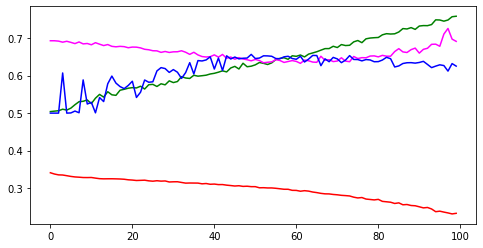

In [34]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['accuracy'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_accuracy'],color='blue')
plt.show()